In [25]:
#get dataframe of tweet_id and user_id
import pandas
import csv
from twython import Twython
import time
from collections import defaultdict

df = pandas.read_csv('gamergate_tweets.csv')
user_ids = df['user_id'].tolist()[:5000]

# Consumer & Auth keys and tokens for authentication
CONSUMER_KEY = "48r56upQvsnTiSDfY4CNwIpCQ"
CONSUMER_SECRET = "VqZhFW7GqogdKXJnpuS0umVe211bFgoCdaQlRdRMayvrbdDh3k"
OAUTH_TOKEN = "18000528-Scl8a1pLinqP4KWtaa3f8EN0M1vqAGTyYXMtsLIGm"
OAUTH_TOKEN_SECRET = "NcIvLeqVbwwBegabvo7946FVIaDN0CAaJ7aS2aV7pZFzC"

twitter = Twython(
    CONSUMER_KEY, CONSUMER_SECRET,
    OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

#%run Get\ Tweets.ipynb
###########
'''
start = 0
end = 100
tweet_list = []
while end <= 5000:
    id_list = df["tweet_id"].tolist()
    current = id_list[start:end]
    tweet = twitter.lookup_status(id=current)
    start += 100
    end += 100
    for t in tweet:
        each_tweet = []
        each_tweet.append(t['user']['id'])
        each_tweet.append(t["retweet_count"])
        each_tweet.append(t["favorite_count"])
        if t["entities"]['urls'] != []:
            each_tweet.append(1)
        else: each_tweet.append(0)
        if t["entities"]["user_mentions"] == []:
            each_tweet.append([])
        else: 
            y = 0
            mentionlist = []
            while y < len(t["entities"]["user_mentions"]):
                mentionlist.append((t["entities"]["user_mentions"])[y].items()[2][1])
                y+=1
            each_tweet.append(mentionlist)
        each_tweet.append(t["text"])
        tweet_list.append(each_tweet)
tweets_df = pandas.DataFrame(tweet_list, columns=["User ID", "Retweets", "Favorites", "Has_url", "Mentions", "Text"])
###########

# check rate limit
# twitter.get_application_rate_limit_status()['resources']['followers']
'''

         User ID  Retweets  Favorites  Has_url  \
0       20708129       363          0        0   
1       20945241         1          0        0   
2      251045973         0          0        0   
3     1091189214         1          0        0   
4     2847688135         0          0        1   
5     2798609018         0          0        0   
6     2492324996       794          0        1   
7       93363347       238          0        1   
8      937178150        27          0        0   
9       36790442         0          0        1   
10    2590712055        33          0        1   
11      16326705       967          0        0   
12     985889652        80          0        1   
13      18746944       238          0        1   
14     162572003         0          1        0   
15     940132086       228          0        0   
16      49534986        19          0        0   
17     171848975         0          0        0   
18      49724410         0          0        0   


NameError: name 'sm' is not defined

'\nstart = 0\nend = 100\ntweet_list = []\nwhile end <= 5000:\n    id_list = df["tweet_id"].tolist()\n    current = id_list[start:end]\n    tweet = twitter.lookup_status(id=current)\n    start += 100\n    end += 100\n    for t in tweet:\n        each_tweet = []\n        each_tweet.append(t[\'user\'][\'id\'])\n        each_tweet.append(t["retweet_count"])\n        each_tweet.append(t["favorite_count"])\n        if t["entities"][\'urls\'] != []:\n            each_tweet.append(1)\n        else: each_tweet.append(0)\n        if t["entities"]["user_mentions"] == []:\n            each_tweet.append([])\n        else: \n            y = 0\n            mentionlist = []\n            while y < len(t["entities"]["user_mentions"]):\n                mentionlist.append((t["entities"]["user_mentions"])[y].items()[2][1])\n                y+=1\n            each_tweet.append(mentionlist)\n        each_tweet.append(t["text"])\n        tweet_list.append(each_tweet)\ntweets_df = pandas.DataFrame(tweet_list, c

In [3]:
# GET followers/list
def get_follower_list(twitter, user_id):
    followers = []
    cursored = twitter.cursor(twitter.get_followers_list, id=user_id)
    for follower in cursored:
        followers.append(follower)
    return followers

# GET users/lookup
def get_user_lookup(twitter, current):
    user_obj = twitter.lookup_user(user_id=current)
    return user_obj
    
# GET followers/ids
def get_follower_ids(twitter, user_id):
    followers = []
    cursored = twitter.cursor(twitter.get_followers_ids, id=user_id)
    for follower in cursored:
        followers.append(follower)
    return followers

In [4]:
user_list = []
start = 0
end = 100
while end <= 5000:
    current = user_ids[start:end]
    start += 100
    end += 100
    users = get_user_lookup(twitter, current)
    for i in range(0, len(users)):
        each_user = []
        each_user.append(user_ids[i]) # user[0] = user_id
        each_user.append(users[i]['followers_count']) # user[1] = follower count
        each_user.append(users[i]['favourites_count'])
        each_user.append(users[i]['location'])
        user_list.append(each_user)

In [124]:
users_df = pandas.DataFrame(user_list, columns=["User ID", "Follower Count", "Favourites Count", "Location"])
tweets_df = pandas.read_csv("tweets.csv")
print tweets_df.info()
#print users_df.sort_values(["Follower Count", "Favourites Count",], ascending=[False, False])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9784 entries, 0 to 9783
Data columns (total 9 columns):
User ID        9783 non-null float64
Retweets       9784 non-null float64
Favorites      9784 non-null int64
Has_url        9784 non-null int64
Mentions       9783 non-null object
Text           9781 non-null object
Polarity       9782 non-null float64
Popularity     9782 non-null float64
numMentions    9782 non-null float64
dtypes: float64(5), int64(2), object(2)
memory usage: 764.4+ KB
None


In [127]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans
import seaborn as sns
from scipy import cluster
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline

def evaluate_clusters(X, max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_
    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')
    


Populating the interactive namespace from numpy and matplotlib


n_samples: 9780, n_features: 30
[u'anger', u'anti', u'attack', u'chsommers', u'fuels', u'gawker', u'gender', u'gg', u'good', u'hate', u'joined', u'know', u'media', u'money', u'narrative', u'outrage', u'people', u'playdangerously', u'power', u'really', u'sargon_of_akkad', u'sides', u'stop', u'support', u'think', u'time', u'tired', u'video', u'waxpancake', u'women']
[[ -1.80128026e-02   4.84653240e-02   5.64706133e-02 ...,  -9.61096046e-02
    6.29556727e-01  -5.14710677e-01]
 [  7.76294512e-02   1.09973807e-02   1.02828421e-01 ...,   6.88295479e-01
    7.02137108e-01  -5.33055444e-03]
 [  1.34184513e-03   4.46015566e-02  -6.18197053e-02 ...,  -5.96051048e-01
    4.09931280e-01  -4.07881106e-01]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  2.14099398e-02   1.92054170e-02   4.82008323e-02 ...,  -8.91864322e-02
    4.34378307e-02  -6.07285505e-04]
 [  3.33573821e-02   3.84758959e-02   6.04867487e-01 ...,  -1.1804

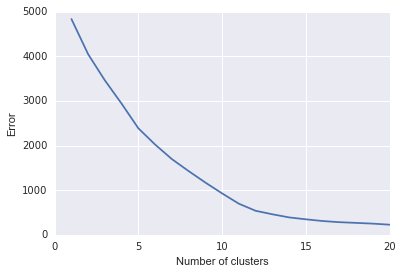

In [137]:
text_list = tweets_df.dropna().Text.values
vectorizer = TfidfVectorizer(max_df=.9, max_features=25,
                             min_df=3, stop_words='english',
                             use_idf=True)

#print vectorizer.get_feature_names()
stop_words = list(vectorizer.get_stop_words())
stop_words.append('like')
stop_words.append('just')
stop_words.append('tweets')
stop_words.append('twitter')
stop_words.append("gamers")
stop_words.append("gamer")
stop_words.append("games")
stop_words.append("game")
stop_words.append("month")
stop_words.append("hours")
stop_words.append("20")
stop_words.append("want")
stop_words.append("don")
stop_words.append("did")
stop_words.append("ve")

vect = TfidfVectorizer(max_df=.9, max_features=30,
                             min_df=3, stop_words=stop_words,
                             analyzer='word', use_idf=True)

X = vect.fit_transform(text_list)
X_prime = vectorizer.fit_transform(text_list)
print("n_samples: %d, n_features: %d" % X.shape)
print vect.get_feature_names()

svd = TruncatedSVD(10)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(X)
#explained_variance = svd.explained_variance_ratio_.sum()
#print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

evaluate_clusters(X,20)

print X

Init 1/1 with method: k-means++
Inertia for init 1/1: 74.109992
Minibatch iteration 1/1000: mean batch inertia: 0.071188, ewa inertia: 0.071188 
Minibatch iteration 2/1000: mean batch inertia: 0.081449, ewa inertia: 0.073286 
Minibatch iteration 3/1000: mean batch inertia: 0.080456, ewa inertia: 0.074753 
Minibatch iteration 4/1000: mean batch inertia: 0.068017, ewa inertia: 0.073375 
Minibatch iteration 5/1000: mean batch inertia: 0.071813, ewa inertia: 0.073056 
Minibatch iteration 6/1000: mean batch inertia: 0.075159, ewa inertia: 0.073486 
Minibatch iteration 7/1000: mean batch inertia: 0.075284, ewa inertia: 0.073853 
Minibatch iteration 8/1000: mean batch inertia: 0.070411, ewa inertia: 0.073149 
Minibatch iteration 9/1000: mean batch inertia: 0.079429, ewa inertia: 0.074433 
Minibatch iteration 10/1000: mean batch inertia: 0.088875, ewa inertia: 0.077386 
Minibatch iteration 11/1000: mean batch inertia: 0.086947, ewa inertia: 0.079341 
Converged (lack of improvement in inertia) 

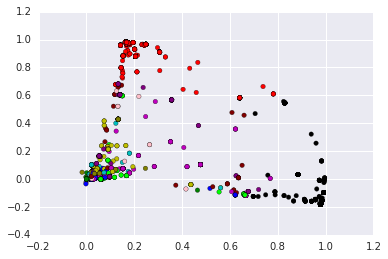

In [138]:
#kmeans = KMeans(n_clusters=12, init='k-means++', max_iter=100, n_init=1, verbose=True)
#y_pred = kmeans.fit(X)
kmeans = MiniBatchKMeans(n_clusters=12, init='k-means++', n_init=1,
                     init_size=1000, batch_size=1000, verbose=True)
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

#kmeans = KMeans(init='k-means++', n_clusters=7, n_init=20)
y_pred = kmeans.fit_predict(X)
#y_pred = km.fit_predict(X)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_
colors = np.array([x for x in ('b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'lime', 'maroon', 'olive', 'pink')])
colors = np.hstack([colors] * 20)
#x = np.random.random(12)
#y = np.random.random(12)
#c = np.random.random(12)  # color of points

#fig, ax = plt.subplots()
#im = ax.scatter(X[:, 0], X[:, 1], c=c, cmap=plt.cm.jet)
plt.scatter(X[:, 0], X[:, 1], c=colors[y_pred].tolist())#, color=colors[y_pred].tolist())

In [24]:
#polar_user_df = tweets_df.loc[tweets_df['Polarity'].isin([-4, 3])]
pop_user_df = tweets_df.sort_values('Popularity', ascending=False)[:20]
polar_user_df.drop(['Text', 'Has_url', 'Retweets', 'Favorites'], axis=1, inplace=True)
polar_users = polar_user_df['User ID']

KeyError: 'Popularity'

In [12]:
print polar_user_df.info()
follower_ids = defaultdict(list)
i = 0
remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
while i < len(polar_users):
    print polar_users.iloc[i]
    if remaining < 1:
        print "start waiting"
        time.sleep(930)
        print "done waiting"
        remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
    else:
        follower_ids[polar_users.iloc[i]] = get_follower_ids(twitter, polar_users.iloc[i])
        remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
        i += 1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 1773 to 2448
Data columns (total 4 columns):
User ID       21 non-null int64
Mentions      21 non-null object
Polarity      21 non-null int64
Popularity    21 non-null int64
dtypes: int64(3), object(1)
memory usage: 840.0+ bytes
None
2801289353
14 2801289353
2368624716
12 2368624716
1317712621
11 1317712621
16088388
10 16088388
1498976455
9 1498976455
104519838
8 104519838
1499808391
6 1499808391
2788941283
5 2788941283
24610050
1 24610050
2837175356
0 2837175356
857720059
start waiting
done waiting


TwythonError: HTTPSConnectionPool(host='api.twitter.com', port=443): Read timed out. (read timeout=None)

In [14]:
print len(follower_ids.keys())
# find out tweets that belongs to followers of the 21 popular users
# make a df of all the tweets for each popular user
follower_dfs = []
for p in polar_users:
    df = tweets_df.loc[tweets_df['User ID'].isin(follower_ids[p])]
    follower_dfs.append(df)
    

21


In [19]:
# pay attention to 574962273, 1499808391, 854203626
count_list = []
polar_mean = []
for i in range(len(follower_dfs)):
    count_list.append(follower_dfs[i].shape[0])
    polar_mean.append(follower_dfs[i].Polarity.mean())

polar_user_df["Follower Tweets Count"] = np.array(count_list)
polar_user_df["Follower Polarity Mean"] = np.array(polar_mean)
print polar_user_df.info()

/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 1773 to 2448
Data columns (total 6 columns):
User ID                   21 non-null int64
Mentions                  21 non-null object
User Polarity             21 non-null int64
Popularity                21 non-null int64
Follower Tweets Count     21 non-null int64
Follower Polarity Mean    9 non-null float64
dtypes: float64(1), int64(4), object(1)
memory usage: 1.1+ KB
None


In [20]:
polar_user_df.rename(index=str, columns={"Polarity": "User Polarity"}, inplace=True)